# basic cnn lstm model design

CNN LSTM models have more than one specific type of a "depth" they bring to bear on a given problem.

first, CNN LSTMs have a *depth of time*: think [back propogation through time (BPTT)](https://en.wikipedia.org/wiki/Backpropagation_through_time "back propogation through time") and/or [truncated back propogation through time (TBPTT)](https://r2rt.com/styles-of-truncated-backpropagation.html "truncated back propogation through time").

CNN LSTM models also have a *depth of space*, with their multiple layers--convolutional, pooling, flattening, lstm etc--creating a deep, highly specialized and memory-persistent network.

>*[CNN LSTMs are] a class of models that is both spatially and temporally deep,
and has the flexibility to be applied to a variety of vision tasks involving sequential
inputs and outputs*
>
>— Long-term Recurrent Convolutional Networks for Visual Recognition and Description, 2015

in CNN LSTM architecture, convolutional neural networks act as encoders, effectively translating visual imagery into vector space--such that an LSTM RNN can effectively process it.

CNNs "in the wild" (as it were) are usually designed to process a single image at a time. however, with a few adjustments they can provide effective [feature extraction](https://en.wikipedia.org/wiki/Feature_extraction "feature extraction") for visual time sequence data, like video.

of course, time series problems are perfect for cells with longer-term "memory", like LSTMs.

in this notebook, we'll use a visual time series problem--specifically, the task of classifying a simple video--to illustrate the `keras` api for CNN LSTM model design.

#### two models working as one

to build the model, we'll start by defining a convolutional neural network with 2D conv and max pooling layers--standard CNN stuff.

we'll then use the `keras` `TimeDistributed()` wrapper to prepare the CNN to output series data that an LSTM expects.

once our CNN is time-distributed, we can connect it to an LSTM and start classifying videos.

## data

this video prediction problem centers on the model's ability, given several frames of a line moving across a box, to properly classify which direction the line is moving in.

the problem is contrived so that the data will be easy to generate (and also thus unlimited), but it does demonstrate the CNNs ability to encode & extract features from visual data, and the LSTM's ability to find some order (and retain that order) over the course of analyzing a sequence of information.

*(python script to generate this data, with a few modifications, is from [jason brownlee's excellent course in LSTMs](www.machinelearningmastery.com), available at www.machinelearningmastery.com)*

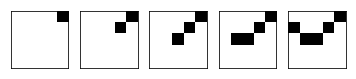

In [2]:
from numpy import zeros
from random import randint
from random import random
from matplotlib import pyplot
%matplotlib inline

# generate the next frame in the sequence
def next_frame(last_step, last_frame, column):
    
    # define the scope of the next step
    lower = max(0, last_step-1)
    upper = min(last_frame.shape[0]-1, last_step+1)
    
    # choose the row index for the next step
    step = randint(lower, upper)
    
    # copy the prior frame
    frame = last_frame.copy()
    
    # add the new step
    frame[step, column] = 1
    
    return frame, step

# generate a sequence of frames of a dot moving across an image
def build_frames(size):
    
    frames = list()
    
    # create the first frame
    frame = zeros((size,size))
    
    step = randint(0, size-1)

    # decide if we are heading left or right
    right = 1 if random() < 0.5 else 0
    
    col = 0 if right else size-1
    
    frame[step, col] = 1
    
    frames.append(frame)

    # create all remaining frames
    for i in range(1, size):
        
        col = i if right else size-1-i
        
        frame, step = next_frame(step, frame, col)
        
        frames.append(frame)
    
    return frames, right

# generate sequence of frames
size = 5

frames, right = build_frames(size)

# plot all frames
pyplot.figure()

for i in range(size):
    
    # create a gray scale subplot for each frame
    pyplot.subplot(1, size, i+1)
    
    pyplot.imshow(frames[i], cmap='Greys')

    # turn of the scale to make it clearer
    ax = pyplot.gca()
    
    ax.get_xaxis().set_visible(False)
    
    ax.get_yaxis().set_visible(False)
    

with the functions above, we can generate a pseudorandom sequence of images like these as many times as we want.

>*it's worth noting here that many apparently [stochastic](https://en.wikipedia.org/wiki/Stochastic_process "stochastic processes") processes in fact follow predictable [distributions](https://en.wikipedia.org/wiki/Gaussian_process "wikipedia: gaussian distribution") and thus pseudorandom generation should be sufficient for our data purposes.*

## preparing data for a 2d cnn

a 2d convolutional neural network normally accepts data in 3 dimensions: *width, height,* and *channels*.

our data has:

* the __same width__ and __height__, equal to `size` in the data-generation function above

* 1 __channel__ (greyscale)

we can begin to define our 2d CNN input as `[size, size, 1]`.

### multiple time steps as input to CNNs

the vector `[size, size, 1]` would work for a single image fed into a cnn. however, we have *multiple images*, i.e. __multiple time steps__.

on top of this, we have multiple instances (samples) of each set of time steps.

__we need more dimensions__.

adding time steps and samples as input dimensions gives us the vector `[n_samples, n_timesteps, size, size, 1]`.

because the function above generates a number of timesteps equal to whatever the `size` variable is set to, __our version of this input shape is__
> `[n_samples, size, size, size, 1]`

with this in mind, it's easy to build a function that generates data for us, immediately reshaping it into a format suitable for multiple time steps as input to a cnn:

In [3]:
import numpy as np

def make_samples(size, n_samples):
    
    X, y = list(), list()
    
    for sample in range(n_samples):
        
        frames, right = build_frames(size)
        
        # this is where our frames go
        
        X.append(frames)
        
        # vector of boolean values for right
        
        y.append(right)
        
    # reshape the data to fit cnn
    # [n_samples, n_timesteps, width, height, channels]
    # using numpy array().reshape()
    
    X = np.array(X).reshape(n_samples, size, size, size, 1)
    
    y = np.array(y).reshape(n_samples, 1)
    
    return X, y

the `make_samples()` function will generate as many samples of whatever size we need, making a typical *train test split* (a method of reserving data from training to be tested on sight unseen) unnecessary.

## define & compile

in modeling terms, the difficulty of the problem depends on the size of the images being analyzed. 

a 50-pixel by 50-pixel image is a moderately difficult problem for this model to learn. we'll set `size` equal to 50.

### components of the cnn model

our cnn model is effectively an encoder/feature extractor for our lstm model.

we will be using `Conv2D` layers wrapped in `TimeDistributed` layers to allow for processing multiple time steps. we will use 2 filters, and a small 2x2 kernel for reading in the image data. our activation function will be [rectified linear units](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) "wikipedia: relu"), aka `relu`.

after our `Conv2D` layers, we'll define a `MaxPooling2D` layer (as is typical for CNNs) that will cut the `Conv2D` layer's two 49-pixel-by-49-pixel outputs in half, to a vector of `[24, 24, 2]`.

finally, the `Flatten` layer will transform `MaxPoolingLayer`'s `[24, 24, 2]` vector down to a single-dimension vector with 1,152 elements.

> *while* `MaxPooling2D` *outputs a 3-dimensional* `[24, 24, 2]` *vector, the* `Flatten` *layer compresses it down to a 1-dimensional vector with* `24 * 24 * 2 = 1,152` *elements: hence the name "flatten".*

### components of the lstm model

#### input:

our lstm model will consist of 

* __1 layer__, with 

* __50 cells__

recall that the cnn model is wrapped in a `TimeDistributed` layer to allow for multiple time steps. also recall that the `Flatten` layer takes earlier convolutional and pooling layer inputs, and flattens them down to a 1d, 1,152-element vector.

what this means in practical terms for our lstm: __for each sample, the lstm model will see__

* __50 time steps__, each having a 1d vector of

* __1,152 values__

#### output:

since this is a binary classification problem, we only need one neuron for our `Dense` output layer.

#### configuration:

we're down to the final configuration details.

for this problem, our model will use:

* a [__sigmoid activation function__](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6 "towards data science: activation functions")
* [__logarithmic loss__](http://wiki.fast.ai/index.php/Log_Loss "fast ai log loss wiki") (ie `binary_crossentropy`), minimized using
* [__adam gradient descent__](https://arxiv.org/abs/1412.6980 "arxiv: adam gradient descent") optimizer

lastly, we'll compile our model with instructions to report the classification accuracy.

In [4]:
# we're building a Sequential model, with
# lots of different types of layers

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed

# define the problem

size = 50

# define the model

cnn_lstm_model = Sequential()

# add 1st (and in this case only) Conv2D layer
# wrap in TimeDistributed() layer

cnn_lstm_model.add(TimeDistributed
                   (Conv2D(2, (2,2), activation='relu'), 
                    input_shape=(None, size, size, 1)))

# MaxPooling layer, also wrapped in TimeDistributed

cnn_lstm_model.add(TimeDistributed
                  (MaxPooling2D(pool_size=(2, 2))))

# Flatten layer, wrapped in TimeDistributed

cnn_lstm_model.add(TimeDistributed
                  (Flatten()))

# lstm layer with 50 memory cells

cnn_lstm_model.add(LSTM(50))

# dense output layer with sigmoid activation funtion

cnn_lstm_model.add(Dense(1, activation='sigmoid'))

# compile with log loss & adam SGD optimizer

cnn_lstm_model.compile(loss='binary_crossentropy', 
                      optimizer='adam', metrics=['acc'])

stats = cnn_lstm_model.summary()

print(stats)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 49, 49, 2)   10        
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 24, 24, 2)   0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 1152)        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                240600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 240,661
Trainable params: 240,661
Non-trainable params: 0
_________________________________________________________________
None


the model sumamry confirms the shape of each of our layers. 

in total, our model has 240,661 parameters.

*note: when i originally ran this cell, i forgot to specify the* `size` *variable--the only clue was that the model summary showed i had far too few parameters for a model this size. printing out & carefully reviewing stats ftw!*

## fit the model

##### design note: there are a couple of frameworks we can use to train a model, in general.

on one hand, we can train the model using a smaller dataset with a large number of epochs. this is certainly a solid option when data is limited.

optimally, however, it is better to train any model using a large number of unique samples, in one big epoch. in contrast to the first potential method, the model will (in general) see each sample only once, instead of multiple times.

this helps keep the model from memorizing the data--in other words, overfitting (and thus being poorly generalizable, if at all).

because we can generate as much or little data as we need, we will choose the second method here. we'll generate a *large number of __samples__*, and allow our model to see each one once: training on the dataset for *one __epoch__*.

for speedier training, we'll set the *__batch_size__* (number of samples between back propogation weight updates) to 32.

In [5]:
# generate data

X, y = make_samples(size, 4000)

# fit the model

cnn_lstm_model.fit(X, y, batch_size=32, epochs=1)

Epoch 1/1
4000/4000 [==============================] - 29s 7ms/step - loss: 0.2154 - acc: 0.8955


#### in-model stats

on this run, our model took approximately 29 seconds to train on 4,000 samples, with a __loss__ of 0.2154 and an __accuracy__ of 0.8955.

because neural nets are stochastic, a different run of the same code will likely produce *slightly* different results. however, these metrics are still useful for comparing models.

##### a quick note re: memory errors

*because the dataset is generated and stored in local memory, it's possible to run out of ram and receive a nice python `Memory Error`. if this happens while running the code, simply reduce the number of samples.*

*further note: obviously it's better to train on more samples. so keep in mind that reducing the number may affect model performance!*

## model evaluation

we'll use two methods to evaluate our model here.

first, we'll test the model on unseen data--an essential part of understanding whether our model can generalize.

second, we'll use the model to make a prediction, and see how it looks.

### loss and accuracy on unseen data

to get an idea of the model's ability to generalize, we can create a new set of samples and ask the model to make predictions on these.

we'll use `evaluate()` to retrieve the model's performance metrics on the new data.

In [7]:
# create new, unseen data

X, y = make_samples(size, 100)

# get metrics

loss, accuracy = cnn_lstm_model.evaluate(X, y, verbose=0)

# display loss & accuracy converted to percentage

print('model loss: %f, model accuracy: %f' % (loss, accuracy*100))

model loss: 0.010724, model accuracy: 100.000000


### testing an individual prediction

lastly, we'll generate a single random sequence and ask the model to make a prediction of whether the line is moving left or right.

In [11]:
# create new data: a single sample

X, y = make_samples(size, 1)

# get predictions

y_hat = cnn_lstm_model.predict_classes(X, verbose=0)

# store prediction & actual for display

prediction = 'right' if y_hat[0] == 1 else 'left'

actual = 'right' if y[0] == 1 else 'left'

# diplay results

print('model prediction: %s' '\n' 'actual: %s' % (prediction, actual))

model prediction: right
actual: right


cool! our model works.

## thanks for reading!